In [ ]:
import torch 
import torchvision
from torchvision.datasets import MNIST, USPS

import torchvision.transforms as transforms                
import torch.optim as optim
import torch.nn as nn
import tqdm
import click
import numpy as np
import matplotlib.pyplot as plt
import copy

In [ ]:
class flatten(nn.Module):
    
    def __init__(self):
        super(flatten,self).__init__()
    
    def forward(self,x):
        return torch.flatten(x,1)

In [ ]:
class DTNClassifier(nn.Module):
    def __init__(self,):
        super(DTNClassifier,self).__init__()
        self.num_channels = 1
        self.image_size = 32
        self.num_cls = 10
        self.out_dim = 512 # dim of last feature layer
        self.setup_net()
        
    def setup_net(self):
        self.conv_params = nn.Sequential (
                nn.Conv2d(self.num_channels, 64, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm2d(64),
                nn.Dropout2d(0.1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm2d(128),
                nn.Dropout2d(0.3),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm2d(256),
                nn.Dropout2d(0.5),
                nn.ReLU()
                )
    
        self.fc_params = nn.Sequential (
                nn.Linear(256*4*4, 512),
                )
        self.make_flat = flatten()
        self.classifier = nn.Sequential(
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(512, self.num_cls)
                )
        
    def forward(self,x):
        y = self.conv_params(x)
        y = self.make_flat(y)
        y = self.fc_params(y)
        y = self.classifier(y)
        return y



class AAEAddaDTNNet(nn.Module):
    
    def __init__(self,src_net):
        super(AAEAddaDTNNet,self).__init__()
        self.src_net = src_net
        self.src_classifier = nn.Sequential(*list(self.src_net.classifier.children()))
        
        base = list(self.src_net.conv_params.children())
        fc = list(self.src_net.fc_params.children())
        clf = list(self.src_net.classifier.children())
        
        new_classifier = nn.Sequential(nn.Sequential(*base),flatten(),nn.Sequential(*fc))
        self.src_net = new_classifier
        
        self.tgt_net = DTNClassifier()
        
        
        base = list(self.tgt_net.conv_params.children())
        fc = list(self.tgt_net.fc_params.children())
        clf = list(self.tgt_net.classifier.children())
        new_classifier = nn.Sequential(nn.Sequential(*base),flatten(),nn.Sequential(*fc))
        
        self.tgt_net = new_classifier
        
        self.tgt_net.load_state_dict(self.src_net.state_dict())
        self.src_net = self.src_net.eval()
        
        self.setup_net()
        self.criterion = nn.CrossEntropyLoss()
        self.gan_criterion = nn.CrossEntropyLoss()
        self.mse = torch.nn.MSELoss()
    def setup_net(self):
        self.discriminator = nn.Sequential(nn.Linear(512,512),nn.LeakyReLU(),nn.Linear(512,2))
        
        self.decoder = nn.Sequential(nn.Linear(512,512),nn.LeakyReLU(),nn.Linear(512,1024))
    
    def forward(self,x):
        x = self.tgt_net(x)
        
        return self.src_classifier(x)

In [ ]:
def train_adaptation_ae(loader_src, loader_tgt, net, opt_net, opt_dis, opt_dec, epoch,device,ae_weight=0.1):
   
    log_interval = 100 # specifies how often to display
  
    N = min(len(loader_src.dataset), len(loader_tgt.dataset)) 
    joint_loader = zip(loader_src, loader_tgt)
      
    net.train()
    running_loss_g = 0
    running_loss_d = 0
    last_update = -1
    net.to(device)
    for batch_idx, ((data_s, _), (data_t, _)) in enumerate(joint_loader):
        # log basic adda train info
        info_str = "[Train Adda] Epoch: {} [{}/{} ({:.2f}%)]".format(
            epoch, batch_idx*len(data_t), N, 100 * batch_idx / N)
   
        ########################
        # Setup data variables #
        ########################
        data_s = data_s.to(device)#, requires_grad=False)
        data_t = data_t.to(device)#, requires_grad=False)
        
        ##########################
        # Optimize discriminator #
        ##########################

        # zero gradients for optimizer
        opt_dis.zero_grad()
        opt_dec.zero_grad()
        opt_net.zero_grad()
        # extract and concat features
        score_s = net.src_net(data_s)
        score_t = net.tgt_net(data_t)
        f = torch.cat((score_s, score_t), 0)
        
        # predict with discriminator
        pred_concat = net.discriminator(f)

        # prepare real and fake labels: source=1, target=0
        target_dom_s = torch.ones(len(data_s)).long().to(device)#, requires_grad=False)
        target_dom_t = torch.zeros(len(data_t)).long().to(device)#, requires_grad=False)
        label_concat = torch.cat((target_dom_s, target_dom_t), 0)
        
       
        
        # compute loss for disciminator
        loss_dis = net.gan_criterion(pred_concat, label_concat)
        

        # compute discriminator acc
        pred_dis = torch.squeeze(pred_concat.max(1)[1])
        acc = (pred_dis == label_concat).float().mean()
        
        
        if acc.item() < .85:
            loss_dis.backward()

            # optimize discriminator
            opt_dis.step()
        running_loss_d+=loss_dis.item()
        
        
        ######################################
        # train decoder (doesnt all fit in gpu)
        ######################################
        
        # zero gradients for optimizer
        opt_dis.zero_grad()
        opt_dec.zero_grad()
        opt_net.zero_grad()
        # extract and concat features
        score_s = net.src_net(data_s)
        score_t = net.tgt_net(data_t)
        f = torch.cat((score_s, score_t), 0)
        #Reconstruct
        src_recon = net.decoder(score_s)
        tgt_recon = net.decoder(score_t)
        recon_concat = torch.cat((src_recon, tgt_recon), 0)
        true_image_concat = torch.cat((data_s, data_t), 0)
        
        loss_dec = net.mse(recon_concat.view(-1,1,32,32),true_image_concat)
        
        loss_dec.backward()
        #net.cpu()
        opt_dec.step()
        #net.cuda()
        # log discriminator update info
        info_str += " acc: {:0.1f} D: {:.3f}".format(acc.item()*100, loss_dis.item())

        ###########################
        # Optimize target network #
        ###########################

        
        
        # zero out optimizer gradients
        opt_dis.zero_grad()
        opt_dec.zero_grad()
        opt_net.zero_grad()

        # extract target features
        score_t = net.tgt_net(data_t)
        
        # predict with discriinator
        pred_tgt = net.discriminator(score_t)
            
        # create fake label
        label_tgt = torch.ones(pred_tgt.size(0)).long().to(device)#, requires_grad=False)
        tgt_recon = net.decoder(score_t).view(-1,1,32,32)
        
        pred_dis = torch.squeeze(pred_tgt.max(1)[1])
        acc = (pred_dis == label_tgt).float().mean()
        
        # compute loss for target network
        loss_gan_t = net.gan_criterion(pred_tgt, label_tgt)
        loss_recon_t = net.mse(tgt_recon,data_t)
        # only update net if discriminator is strong
        if acc.item() < 0.8:
            
            last_update = batch_idx
            loss = loss_gan_t + ae_weight*loss_recon_t 
            loss.backward()
            # optimize tgt network
            opt_net.step()

        # log net update info
        info_str += " G: {:.3f} acc_g: {:0.1f} Dec: {:.3f}".format(loss_gan_t.item(),acc.item()*100,loss_recon_t.item()) 
        running_loss_g += loss_gan_t.item()
        ###########
        # Logging #
        ###########
        if batch_idx % log_interval == 0:
            print(info_str)

    return last_update,running_loss_g,running_loss_d,net

In [ ]:
def train_network(model,dataloader,opt,criterion,device):
    device = device#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.detach().item()
        
    return running_loss
    

def test_network(model,testloader,device):
    device = device#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #Testing Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct,total

def test_perclass(model,testloader,device):
    model = model.eval()
    device = device#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #Testing classification accuracy for individual classes.
    nb_classes = 10

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    classes=[0,1,2,3,4,5,6,7,8,9]#[0,1,2,3,4,5]
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            #print(labels)
            #print(outputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(predicted)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            c = (predicted == labels).squeeze()
            for i in range(labels.size()[0]):
                label = labels[i]
                class_correct[label] += c[i].detach().item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print('Accuracy of total : %2d %%' % (
             100 * correct / (total*1.0)))
    
    print(confusion_matrix.cpu().detach().numpy())
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print(confusion_matrix.diag().sum()/confusion_matrix.sum())
    return class_correct,class_total,confusion_matrix.cpu().detach().numpy()

In [ ]:
def save_cm(directory,cm):
    np.save(directory,cm)

In [ ]:
def main(src,adapt,tgts,epochs,outdir):
    if src == adapt:
        print('Source and Adapt combo are the same so skipping')
        return -1
    batch_size=100
    epochs = epochs # epochs
   
    transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
    ])
    

    model = DTNClassifier()
    cda = "cuda:0"
    device = torch.device(cda if torch.cuda.is_available() else "cpu")
    model.to(device)
    #Loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_data = torchvision.datasets.MNIST(src, train=True, transform=transform, target_transform=None, download=False)
    loader  = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=0)
    for epoch in tqdm.tqdm(range(20)):
        loss = train_network(model,loader,optimizer,criterion,device)
        print(loss)
    

    mynet = AAEAddaDTNNet(model).to(device)#.cuda()
    base_model = copy.deepcopy(mynet.cpu())
    mynet.to(device)
    c,t,_= test_perclass(mynet,loader,device)
    
    train_data = torchvision.datasets.MNIST(src, train=True, transform=transform, target_transform=None, download=False)
    loader  = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=0)
    
    target_data = torchvision.datasets.USPS(adapt, train=True, transform=transform, target_transform=None, download=False)
    loader_tgt = torch.utils.data.DataLoader(target_data,batch_size=batch_size,shuffle=True,num_workers=0)
    
    

    accs = []
    mynet = copy.deepcopy(base_model.cpu())
    mynet.to(device)
    c,t,_= test_perclass(mynet,loader_tgt,device)
    accs.append(100.0*(sum(c)/(sum(t)*1.0)))
        
    #Optimizer(SGD)
    optimizer = optim.Adam(mynet.tgt_net.parameters(), lr=0.00001)
    optimizer2 = optim.Adam(mynet.discriminator.parameters(), lr=0.005) 
    optimizer3 = optim.Adam(mynet.decoder.parameters(), lr=0.001)
        
    loss_G = []
    loss_D = []
    for epoch in tqdm.tqdm(range(epochs)):
        mynet=mynet.train()
        update,loss_g,loss_d,mynet = train_adaptation_ae(loader,loader_tgt,mynet,optimizer,optimizer2,optimizer3,epoch,device,ae_weight=0.1)

        print(update)
        loss_G.append(loss_g)
        loss_D.append(loss_d)
        c,t,_ = test_perclass(mynet,loader_tgt,device)
        if epoch==0 or (100.0*(sum(c)/(sum(t)*1.0))) > max(accs):
            best_model = copy.deepcopy(mynet.cpu())
            mynet.to(device)
        accs.append(100.0*(sum(c)/(sum(t)*1.0)))
    
        test_perclass(base_model.to(device),loader_tgt,device)
        test_perclass(best_model.to(device),loader_tgt,device)
        plt.figure(figsize=(20,10))
        plt.plot(accs)
        plt.show()
        
        plt.figure(figsize=(20,10))
        plt.plot(loss_G)
        plt.plot(loss_D)
        plt.show()

0it [00:00, ?it/s]


Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 : 45 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 : 29 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 :  0 %
Accuracy of total :  7 %
[[   0.    0. 5258.    0.    0.    0.  665.    0.    0.    0.]
 [   0.    0. 4733.    0.    0.    0. 2009.    0.    0.    0.]
 [   0.    0. 2688.    0.    0.    0. 3270.    0.    0.    0.]
 [   0.    0. 1423.    0.    0.    0. 4708.    0.    0.    0.]
 [   0.    0. 1258.    0.    0.    0. 4584.    0.    0.    0.]
 [   0.    0. 2522.    0.    0.    0. 2899.    0.    0.    0.]
 [   0.    0. 4164.    0.    0.    0. 1754.    0.    0.    0.]
 [   0.    0.  409.    0.    0.    0. 5856.    0.    0.    0.]
 [   0.    0. 2404.    0.    0.    0. 3447.    0.    0.    0.]
 [   0.    0.  366.    0.    0.    0. 5583.    0.    0.    0.]]
tensor([0.0000, 0.0000, 0.4512, 0.0000, 0.0000, 0.0000, 0.2964, 0.0000, 0.0000,
        0.0000

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 : 51 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 : 13 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 :  0 %
Accuracy of total :  6 %
[[  0.   0. 904.   0.   0.   0. 290.   0.   0.   0.]
 [  0.   0. 908.   0.   0.   0.  97.   0.   0.   0.]
 [  0.   0. 373.   0.   0.   0. 358.   0.   0.   0.]
 [  0.   0. 398.   0.   0.   0. 260.   0.   0.   0.]
 [  0.   0. 260.   0.   0.   0. 392.   0.   0.   0.]
 [  0.   0. 106.   0.   0.   0. 450.   0.   0.   0.]
 [  0.   0. 575.   0.   0.   0.  89.   0.   0.   0.]
 [  0.   0. 367.   0.   0.   0. 278.   0.   0.   0.]
 [  0.   0. 265.   0.   0.   0. 277.   0.   0.   0.]
 [  0.   0.  87.   0.   0.   0. 557.   0.   0.   0.]]
tensor([0.0000, 0.0000, 0.5103, 0.0000, 0.0000, 0.0000, 0.1340, 0.0000, 0.0000,
        0.0000])
tensor(0.0634)
[Train Adda] Epoch: 0 [0/7291 (0.00%)] acc: 48.5 D: 0.705 G: 0.500 acc_g: 77.0 Dec

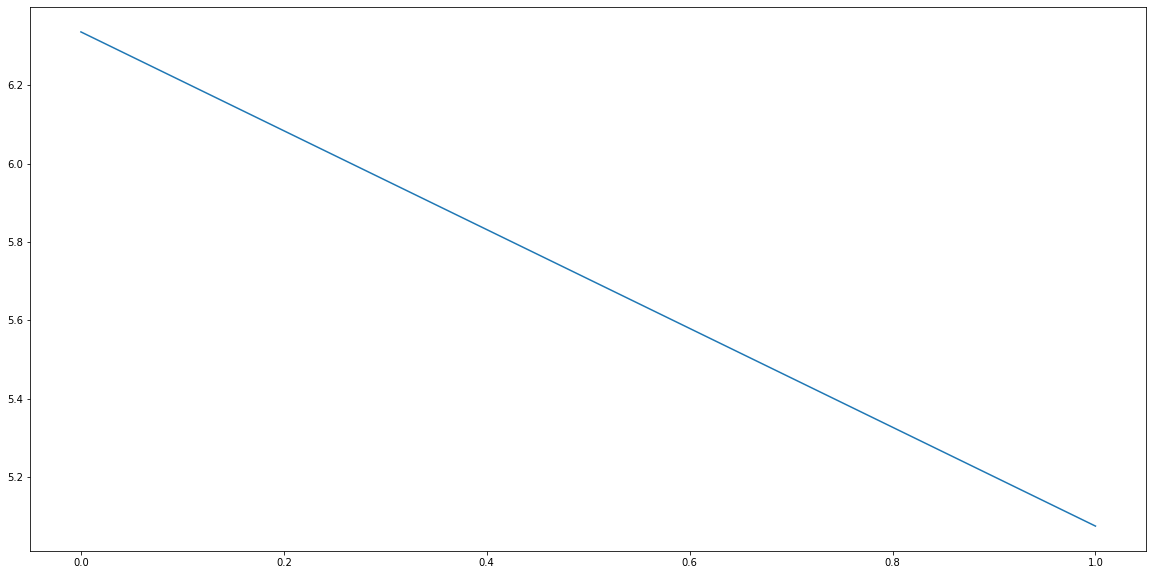

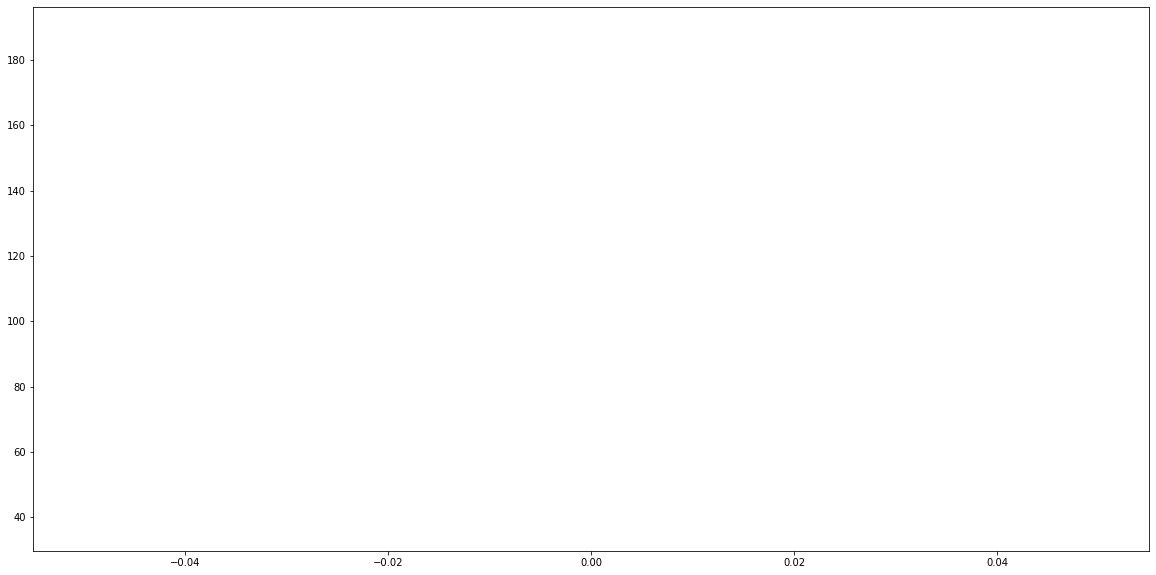

100%|██████████| 1/1 [00:25<00:00, 25.41s/it]


In [ ]:
src_dataset_path = ""
tgt_dataset_path = ""
main(src_dataset_path+'',tgt_dataset_path+'/USPS','',200,'')